# **Практика 5: Атака с ограниченной памятью (PGD Projected Gradient Descent)**

Выполнил студент 2 курса группы: **ББМО-02-23**

ФИО: **Кучренко Иван Дмитриевич**

# **Цель задания:**

Изучить одну из самых эффективных атак на модели искусственного интеллекта — атаку **Projected Gradient Descent (PGD)**. Научиться применять **PGD** для генерации противоречивых примеров и оценить её воздействие на обученные модели.

# **Шаги выполнения:**

## **Шаг 1: Загрузка обученной модели и данных MNIST**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST:
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot:
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели:
model = tf.keras.models.load_model('/content/mnist_model.h5')
# Проверка точности модели на обычных данных:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9752 - loss: 0.0817
Test accuracy on clean images: 0.9778000116348267


##**Шаг 2: Теория атаки Projected Gradient Descent (PGD)**

# Атака **Projected Gradient Descent (PGD)**

Атака **Projected Gradient Descent (PGD)** является итеративным расширением метода **Fast Gradient Sign Method (FGSM)**. В отличие от FGSM, который выполняет атаку за один шаг, PGD добавляет небольшие изменения к входным данным на каждой итерации, что позволяет более точно настраивать противоречивые примеры.

## Механизм работы PGD

На каждой итерации атаки PGD:
1. **Вычисляются градиенты**: Используется градиент функции потерь модели для определения направления, в котором нужно изменить входные данные, чтобы увеличить ошибку классификации.
2. **Обновление входных данных**: К исходным данным добавляется небольшое возмущение, направленное по вычисленным градиентам.
3. **Проекция на допустимое пространство**: После каждого обновления результат "проецируется" обратно в допустимое пространство, чтобы гарантировать, что изменения не превышают заранее определённый предел (например, \(L_{\infty}\) норму).

Эта проекция помогает сохранить противоречивый пример в рамках заданной нормы, что делает атаку более устойчивой и эффективной.

## Применение PGD

PGD используется для создания противоречивых примеров в различных задачах машинного обучения и компьютерного зрения. Эта атака демонстрирует высокую эффективность в снижении точности моделей и выявлении их уязвимостей к адверсативным воздействиям.

##**Шаг 3: Реализация атаки PGD с использованием Foolbox**

 Теперь мы реализуем атаку **PGD**, используя фреймворк **Foolbox**, который упрощает запуск различных атак на модели ИИ

In [16]:
!pip install foolbox

Выборка 10 случайных изображений и отображение результата атаки **PGD**

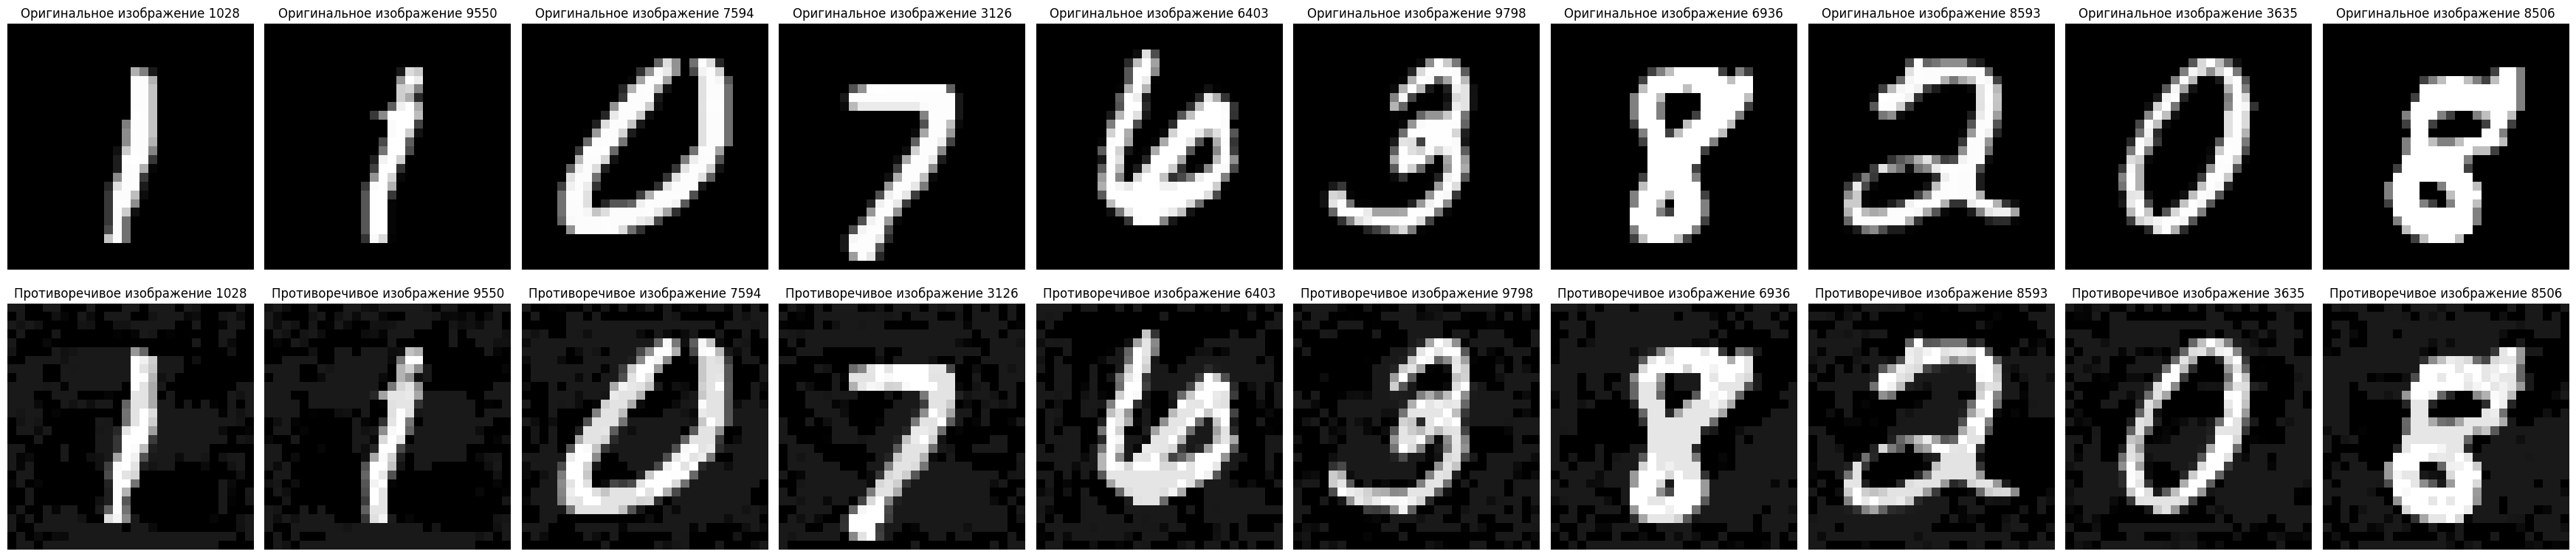

In [19]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация модели Foolbox:
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки PGD:
attack = fb.attacks.LinfPGD()

# Количество изображений для атаки:
num_images = 10

# Случайный выбор индексов изображений из тестового набора:
random_indices = np.random.choice(len(test_images), num_images, replace=False)

# Создание подграфиков для отображения оригинальных и противоречивых изображений:
plt.figure(figsize=(35, 8))

for i in range(num_images):
    # Выбор случайного изображения:
    index = random_indices[i]

    # Подготовка изображения и метки:
    image = tf.convert_to_tensor(test_images[index], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[index])
    label_tensor = tf.convert_to_tensor(label, dtype=tf.int64)

    # Выполнение атаки PGD:
    adversarial_image, _, success = attack(fmodel, image, label_tensor[None], epsilons=0.1)

    # Отображение оригинального изображения:
    plt.subplot(2, num_images, i + 1)
    plt.title(f"Оригинальное изображение {index + 1}")
    plt.imshow(image[0].numpy(), cmap="gray")
    plt.axis('off')

    # Отображение противоречивого изображения:
    plt.subplot(2, num_images, num_images + i + 1)
    plt.title(f"Противоречивое изображение {index + 1}")
    plt.imshow(adversarial_image[0].numpy(), cmap="gray")
    plt.axis('off')

# Настройка отображения графиков
plt.tight_layout()
plt.show()

##**Шаг 4: Оценка модели на противоречивых примерах**

Теперь мы оценим влияние атаки PGD на точность модели. Для этого мы сгенерируем набор противоречивых примеров, состоящий из 100 случайно выбранных изображений, и проанализируем производительность модели на этих данных.

In [24]:
import tensorflow as tf
import numpy as np

# Установка количества изображений:
num_samples = 100

# Случайный выбор индексов изображений:
random_indices = np.random.choice(len(test_images), num_samples, replace=False)

# Инициализация списка для хранения противоречивых изображений:
adversarial_images = []

# Переменные для подсчета успешных атак
successful_attacks = 0
total_attacks = 0

# Генерация противоречивых изображений для выбранных индексов:
for i in random_indices:
    total_attacks += 1  # Увеличиваем общее количество атак
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label_tensor = tf.convert_to_tensor(label, dtype=tf.int64)

    try:
        # Выполнение атаки
        advs, _, success = attack(fmodel, image, label_tensor[None], epsilons=0.1)

        # Проверка успешности атаки
        if success:
            successful_attacks += 1

        adversarial_images.append(advs)
        print(f"Изображение {i + 1}: Атака успешна: {success}")

    except Exception as e:
        print(f"Ошибка при выполнении атаки на изображении {i + 1}: {e}")

# Проверка наличия противоречивых изображений перед объединением
if adversarial_images:
    # Объединение всех противоречивых изображений в один тензор:
    adversarial_images = tf.concat(adversarial_images, axis=0)

    # Оценка модели на противоречивых примерах:
    adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[random_indices])
    print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')
else:
    print("Не удалось создать ни одного противоречивого изображения.")

# Вывод информации о количестве успешных атак
print(f'Количество успешных атак: {successful_attacks} из {total_attacks}')

Изображение 7018: Атака успешна: [ True]
Изображение 9676: Атака успешна: [ True]
Изображение 4036: Атака успешна: [ True]
Изображение 3309: Атака успешна: [ True]
Изображение 692: Атака успешна: [ True]
Изображение 8314: Атака успешна: [ True]
Изображение 7198: Атака успешна: [ True]
Изображение 1476: Атака успешна: [ True]
Изображение 6935: Атака успешна: [ True]
Изображение 4030: Атака успешна: [ True]
Изображение 6576: Атака успешна: [ True]
Изображение 5512: Атака успешна: [ True]
Изображение 2572: Атака успешна: [ True]
Изображение 8648: Атака успешна: [ True]
Изображение 2190: Атака успешна: [ True]
Изображение 9974: Атака успешна: [ True]
Изображение 6831: Атака успешна: [ True]
Изображение 4207: Атака успешна: [ True]
Изображение 900: Атака успешна: [ True]
Изображение 7068: Атака успешна: [ True]
Изображение 5846: Атака успешна: [ True]
Изображение 8628: Атака успешна: [ True]
Изображение 5563: Атака успешна: [ True]
Изображение 4827: Атака успешна: [ True]
Изображение 8164: 

##**Шаг 5: Сравнение результатов**

# Результаты атаки PGD

## Количество успешных атак
Из 100 проведенных атак 94 были успешными, что указывает на высокую эффективность атаки. Это означает, что модель не смогла правильно классифицировать 94% противоречивых изображений, созданных с помощью PGD.

## Точность на противоречивых примерах
Точность модели на противоречивых примерах составила примерно 6%. Это резкое снижение по сравнению с исходной точностью около 97% говорит о том, что модель не устойчива к небольшим изменениям входных данных.


# Причины уязвимости модели

## Чувствительность к шуму
Модели могут быть чрезмерно чувствительны к небольшим изменениям в данных. Это делает их легкими мишенями для атакующих, которые могут использовать даже незначительные изменения для достижения значительных ошибок в классификации.

## Отсутствие регуляризации
Недостаток методов регуляризации может привести к тому, что модель будет слишком сильно подстраиваться под тренировочные данные. Это может уменьшить её способность обобщать на новых примерах и повышает вероятность ошибок при столкновении с противоречивыми примерами.

## Структура сети
Архитектура нейронной сети может быть не оптимизирована для обработки атакующих изменений. Например, если сеть слишком глубокая или сложная, это может привести к переобучению и повышенной уязвимости.